<a href="https://colab.research.google.com/github/LIvanoff/Big-Data-analysis-technologies-and-tools/blob/main/pr4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
import scipy.stats as sts
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Задача 1

Определить два вектора, представляющие собой число автомобилей,
припаркованных в течении 5 рабочих дней у бизнес-центра на уличной
стоянке и в подземном гараже

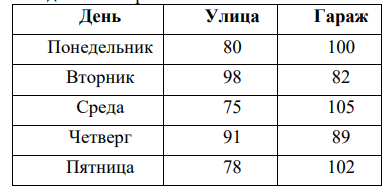

1.1. Найти и интерпретировать корреляцию между переменными
«Улица» и «Гараж» (подсчитать корреляцию по Пирсону).

1.2. Построить диаграмму рассеяния для вышеупомянутых переменных.

In [ ]:
df = pd.DataFrame({'Street': [80, 98, 75, 91, 78],
                   'Parking': [100, 82, 105, 89, 102]})
df

,Street,Parking
0,80,100
1,98,82
2,75,105
3,91,89
4,78,102


In [ ]:
df.corr()

,Street,Parking
Street,1.0,-1.0
Parking,-1.0,1.0


<Axes: >

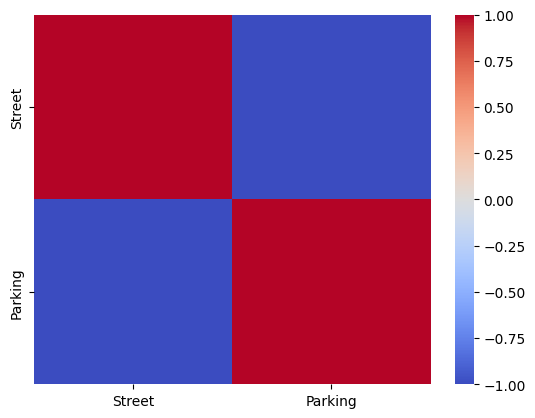

In [ ]:
sns.heatmap(df.corr(), cmap= 'coolwarm')

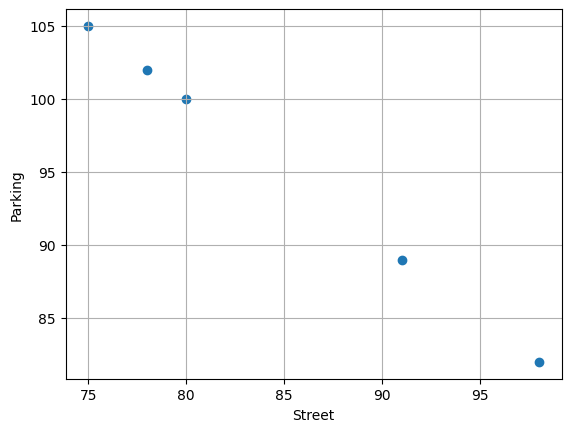

In [ ]:
plt.scatter(x=df.Street, y=df.Parking)
plt.xlabel('Street')
plt.ylabel('Parking')
plt.grid()

## Задача 2

Найти и выгрузить данные. Вывести, провести предобработку и
описать признаки

2.1. Построить корреляционную матрицу по одной целевой переменной.
Определить наиболее коррелирующую переменную, продолжить с
ней работу в следующем пункте.

2.2. Реализовать регрессию вручную, отобразить наклон, сдвиг и MSE.

2.3. Визуализировать регрессию на графике.


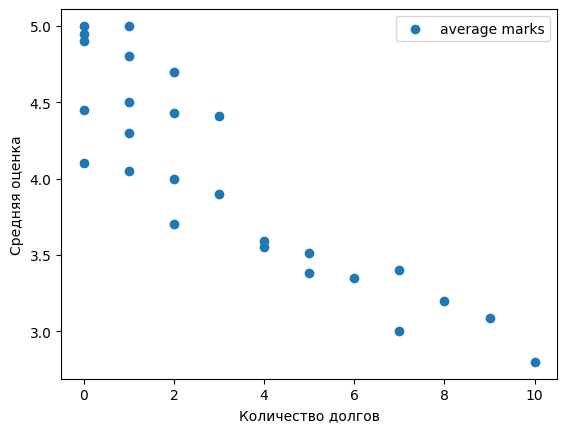

In [ ]:
data = {'average marks': [5, 4.95, 5, 4.9, 4.8, 4.7, 4.5, 4.45, 4.43, 4.41, 4.3, 4.1, 4.05, 4.0, 3.9, 3.7, 3.59, 3.55, 3.51, 3.4, 3.38, 3.35, 3.2, 3.09, 3.0, 2.8],
        'debt nums':     [0, 0,    1, 0,    1,   2,   1,   0,    2,    3,    1,   0,   1,   2,     3,   2,   4,    4,     5,    7,   5 ,    6,   8,   9,   7,   10]}

df = pd.DataFrame(data)
plt.scatter(df['debt nums'],df['average marks'], label='average marks')
plt.ylabel('Средняя оценка')
plt.xlabel(f'Количество долгов')
plt.legend()



In [ ]:
X = df['debt nums'].values
y = df['average marks'].values

X = torch.Tensor(X).unsqueeze(-1)
y = torch.Tensor(y).unsqueeze(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Реализумем регрессию с помощью фреймворка PyTorch, создав модель, состоящую из одного линейного слоя и принимающего входные данные размеров input_dim

In [ ]:
class Regression(nn.Module):
  def __init__(self, n_dim):
    super().__init__()
    self.fc = nn.Linear(n_dim, 1)

  def forward(self, x):
    out = self.fc(x)
    return out

  # эпоха обучения
  def train_epoch(self, X, y, optimizer, loss):
    pred = self.forward(X)
    loss = loss(pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss

  # инициализация оптимизатора и лосса
  def configure(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
    loss = nn.MSELoss()
    return optimizer, loss

  # валидация
  def eval(self, X, y, loss):
    pred = self.forward(X)
    loss = loss(pred, y)
    return loss

  #функция обучения
  def fit(self, epochs, X_train, y_train, X_val, y_val, epsilon=1e-5):
    last_loss = 1e+6
    history = {'train': [], 'val': []}
    optimizer, loss_fn = self.configure()
    for epoch in range(epochs):
      tr_loss = 0.
      val_loss = 0.
      loss = self.train_epoch(X_train, y_train, optimizer, loss_fn)
      tr_loss += loss / len(X_train)
      history['train'].append(tr_loss.item())

      loss = self.eval(X_val, y_val, loss_fn)
      val_loss += loss / len(X_val)
      history['val'].append(val_loss.item())
      if epoch % 100== 0:
        print(f'epoch: {epoch+1} tr_loss: {tr_loss} val_loss: {val_loss}')

      # критерий остановы
      if abs(last_loss - history['val'][-1]) < epsilon:
        return self, history
      last_loss = history['val'][-1]
    return self, history

Обучим нашу модель воспользовавшись Стохастическим градиентым спуском - SGD и Среднеквадратичной ошибкой - MSELoss

epoch: 1 tr_loss: 0.7478373646736145 val_loss: 2.4900574684143066
epoch: 101 tr_loss: 0.2545824646949768 val_loss: 0.8944453597068787
epoch: 201 tr_loss: 0.167723149061203 val_loss: 0.594965398311615
epoch: 301 tr_loss: 0.10209928452968597 val_loss: 0.3662189543247223
epoch: 401 tr_loss: 0.05845998600125313 val_loss: 0.21341271698474884
epoch: 501 tr_loss: 0.03204523026943207 val_loss: 0.12043821066617966
epoch: 601 tr_loss: 0.017405156046152115 val_loss: 0.06852295249700546
epoch: 701 tr_loss: 0.009980747476220131 val_loss: 0.04188096895813942
epoch: 801 tr_loss: 0.006543605122715235 val_loss: 0.029299987480044365
epoch: 901 tr_loss: 0.0050944737158715725 val_loss: 0.023812247440218925
epoch: 1001 tr_loss: 0.0045393346808850765 val_loss: 0.021581709384918213
epoch: 1101 tr_loss: 0.004346553701907396 val_loss: 0.020722737535834312
epoch: 1201 tr_loss: 0.004286008886992931 val_loss: 0.020400697365403175


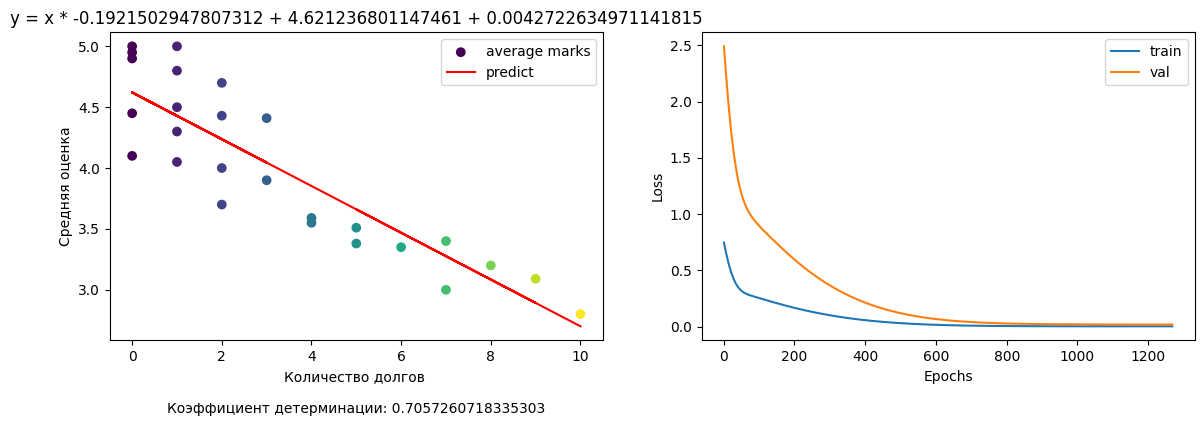

In [ ]:
model = Regression(n_dim=1)
model, history = model.fit(epochs=10000,
          X_train=X_train,
          y_train=y_train,
          X_val=X_test,
          y_val=y_test,
          epsilon=1e-6)

pred = model(X)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].scatter(X, y, label='average marks',c=X)
axes[0].plot(X, pred.detach().numpy(), c='r', label='predict')
axes[0].set_title(f'y = x * {model.fc.weight.item()} + {model.fc.bias.item()} + {history["train"][-1]}')
axes[0].set_ylabel('Средняя оценка')
axes[0].set_xlabel(f'Количество долгов \n\nКоэффициент детерминации: {r2_score(y_test.detach().numpy(), model(X_test).detach().numpy())}')
axes[0].legend()
axes[1].plot(np.arange(1, len(history['train'])+1), history['train'], label='train')
axes[1].plot(np.arange(1, len(history['val'])+1), history['val'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

In [ ]:
print(f' Коэффициент наклона: {model.fc.weight.item()}\n Коэффициент сдвига: {model.fc.bias.item()}\n Значение ошибки: {history["val"][-1]}')

 Коэффициент наклона: -0.19232045114040375
 Коэффициент сдвига: 4.621671199798584
 Значение ошибки: 0.020296012982726097


## Задача 3

Загрузить данные: 'insurance.csv'. Вывести и провести предобработку.
Вывести список уникальных регионов.

3.1. Выполнить однофакторный ANOVA тест, чтобы проверить влияние
региона на индекс массы тела (BMI), используя первый способ,
через библиотеку Scipy.

3.2. Выполнить однофакторный ANOVA тест, чтобы проверить влияние
региона на индекс массы тела (BMI), используя второй способ, с
помощью функции anova_lm() из библиотеки statsmodels.

3.3. С помощью t критерия Стьюдента перебрать все пары. Определить
поправку Бонферрони. Сделать выводы.

3.4. Выполнить пост-хок тесты Тьюки и построить график.

3.5. Выполнить двухфакторный ANOVA тест, чтобы проверить влияние
региона и пола на индекс массы тела (BMI), используя функцию
anova_lm() из библиотеки statsmodels.

3.6. Выполнить пост-хок тесты Тьюки и построить график.

In [ ]:
insurance_df = pd.read_csv('insurance.csv')

In [ ]:
insurance_df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Предобработаем данные

In [ ]:
for i, col in enumerate(insurance_df.region):
  if col == 'southwest':
    insurance_df.loc[i, 'region'] = 0
  elif col == 'southeast':
    insurance_df.loc[i, 'region'] = 1
  elif col == 'northwest':
    insurance_df.loc[i, 'region'] = 2
  else:
    insurance_df.loc[i, 'region'] = 3


In [ ]:
for i, col in enumerate(insurance_df.sex):
  if col == 'male':
    insurance_df.loc[i, 'sex'] = 0
  else:
    insurance_df.loc[i, 'sex'] = 1

In [ ]:
southwest = insurance_df.bmi[insurance_df['region'] == 0]
southeast = insurance_df.bmi[insurance_df['region'] == 1]
northwest = insurance_df.bmi[insurance_df['region'] == 2]
northeast = insurance_df.bmi[insurance_df['region'] == 3]

### 3.1

Теперь проведём однофакторный ANOVA тест, чтобы проверить влияние региона на индекс массы тела

In [ ]:
sts.f_oneway(southwest, southeast, northwest, northeast)

F_onewayResult(statistic=39.49505720170283, pvalue=1.881838913929143e-24)

Как можно видеть p-value меньше 0.05, а значит мы отвергаем нулевую гипотезу и можем сказать, что фактор региона оказывает статистически значимое влияение на индекс массы тела

### 3.2

In [ ]:
model = ols('bmi ~ region', data = insurance_df).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
anova_result

,sum_sq,df,F,PR(>F)
region,4055.880631,3.0,39.495057,1.881839e-24
Residual,45664.319755,1334.0,NaN,NaN


В данном тесте мы также получили очень маленькое значение p-value равное 1.881839e-24

### 3.3

In [ ]:
region_pairs = {'southwest-southeast': [southwest, southeast],
                'southwest-northwest': [southwest, northwest],
                'southwest-northeast': [southwest, northeast],
                'southeast-northwest': [southeast, northwest],
                'southeast-northeast': [southeast, northeast],
                'northwest-northeast': [northwest, northeast]}

for key in region_pairs.keys():
  print(key)
  print(f'{sts.ttest_ind(region_pairs[key][0], region_pairs[key][1])}\n')

southwest-southeast
TtestResult(statistic=-5.908373821545118, pvalue=5.4374009639680636e-09, df=687.0)

southwest-northwest
TtestResult(statistic=3.2844171500398582, pvalue=0.001076958496307695, df=648.0)

southwest-northeast
TtestResult(statistic=3.1169000930045923, pvalue=0.0019086161671573072, df=647.0)

southeast-northwest
TtestResult(statistic=9.25649013552548, pvalue=2.643571405230106e-19, df=687.0)

southeast-northeast
TtestResult(statistic=8.790905562598699, pvalue=1.186014937424813e-17, df=686.0)

northwest-northeast
TtestResult(statistic=0.060307727183293185, pvalue=0.951929170821864, df=647.0)



На основе полученных результатов теста можно сказать, что фактор региона оказывает значимое влияние, кроме одного случая, когда речь идёт о регионах northwest и northeast

### 3.4

In [ ]:
insurance_df.region.unique()

array([0, 1, 2, 3], dtype=object)

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,2.7594,0.0,1.6108,3.9079,True
0,2,-1.3968,0.0127,-2.5774,-0.2162,True
0,3,-1.4231,0.0107,-2.6046,-0.2416,True
1,2,-4.1562,0.0,-5.3047,-3.0077,True
1,3,-4.1825,0.0,-5.332,-3.033,True
2,3,-0.0263,0.9999,-1.2078,1.1552,False


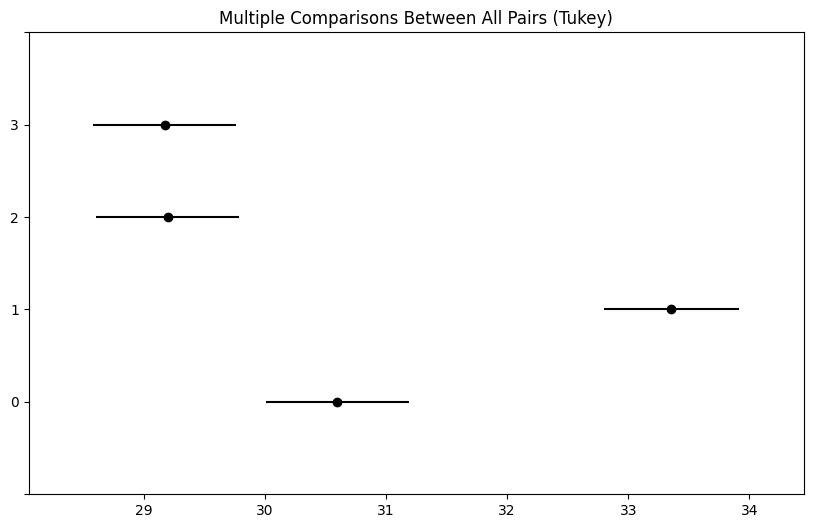

In [ ]:
tukey = pairwise_tukeyhsd(endog=insurance_df.bmi, groups=insurance_df['region'], alpha=0.05)
tukey.plot_simultaneous()
tukey.summary()

Из результатов данного теста можно судить о том что различия между northwest и northeast не существенные

### 3.5

In [ ]:
model = ols('bmi ~ region + sex + region:sex', data = insurance_df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
region,4034.975135,3.0,39.398134,2.163195e-24
sex,86.007035,1.0,2.519359,1.126940e-01
region:sex,174.157808,3.0,1.700504,1.650655e-01
Residual,45404.154911,1330.0,NaN,NaN


В данном случае p-value для региона и пола составило 1.650655e-01, что больше 0.05, что говорит нам об отсутствии значительного эффекта взаимодействия между полом и регионом

### 3.6

In [ ]:
insurance_df = pd.read_csv('insurance.csv')

In [ ]:
insurance_df['combination'] = insurance_df.region + " / " + insurance_df.sex

group1,group2,meandiff,p-adj,lower,upper,reject
northeast / female,northeast / male,-0.2998,0.9998,-2.2706,1.6711,False
northeast / female,northwest / female,-0.0464,1.0,-2.0142,1.9215,False
northeast / female,northwest / male,-0.2042,1.0,-2.1811,1.7728,False
northeast / female,southeast / female,3.3469,0.0,1.41,5.2839,True
northeast / female,southeast / male,4.6657,0.0,2.7634,6.568,True
northeast / female,southwest / female,0.7362,0.9497,-1.2377,2.71,False
northeast / female,southwest / male,1.8051,0.1007,-0.1657,3.776,False
northeast / male,northwest / female,0.2534,0.9999,-1.7083,2.2152,False
northeast / male,northwest / male,0.0956,1.0,-1.8752,2.0665,False
northeast / male,southeast / female,3.6467,0.0,1.7159,5.5775,True


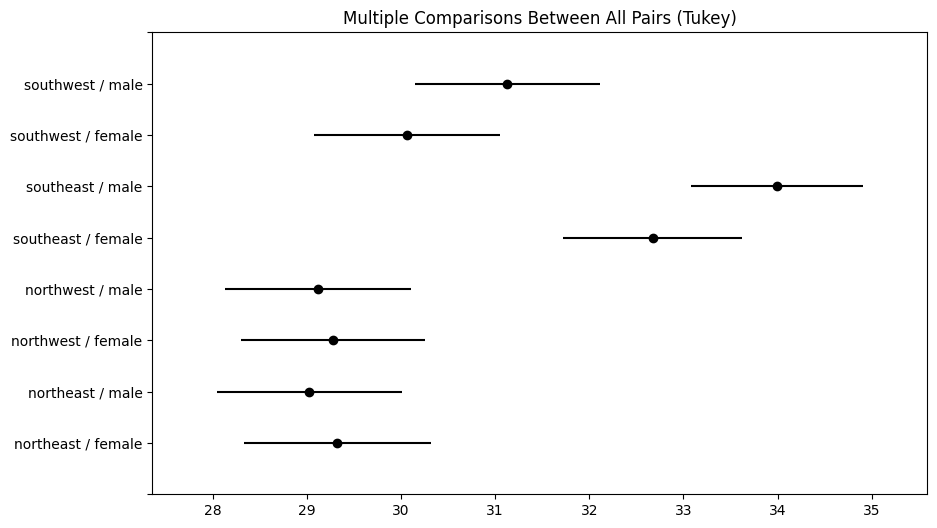

In [ ]:
tukey = pairwise_tukeyhsd(endog=insurance_df.bmi, groups=insurance_df['combination'], alpha=0.05)
tukey.plot_simultaneous()
tukey.summary()

Результаты данного теста показывают отстуствие существенной разницы между мужщинами и женщинами регионов northwest и northeast, а также имеющуюся разницу между женщинами и мужчинами из регионов southwest и southeast